In [ ]:
from fastformer import FastformerForCausalLM, FastformerLMConfig
from transformers import TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset

from itertools import chain

# redundant imports to reload library to allow for easy editing of fastformer code
import importlib
import fastformer
importlib.reload(fastformer)
FastformerForCausalLM = fastformer.FastformerForCausalLM
FastformerLMConfig = fastformer.FastformerLMConfig

In [ ]:
# character tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")

In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-2-raw-v1")
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]
block_size = 1024

def tokenize_function(examples):
    output = tokenizer(examples[text_column_name])
    return output

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=1,
            remove_columns=column_names,
        )

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=1,
    desc=f"Grouping texts in chunks of {block_size}",
)

lm_dataset.set_format('pt')

Reusing dataset wikitext (C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-c8897eeb5ed8a4b8.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-0da6923e3ea9fc5e.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8c5064826564cc2e.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8618f92441aa4df7.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126

In [ ]:
# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "epoch",
    evaluation_strategy ="epoch",
    report_to = "none",
    learning_rate = 10e-4,
    num_train_epochs = 50,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    save_strategy = "epoch",
)

config = FastformerLMConfig(
    hidden_size = 256, vocab_size = len(tokenizer),
    max_position_embeddings = block_size, groups = 2, kernel_size = 4,
    convolve = False, num_hidden_layers = 6, hidden_dropout_prob= .1,
    initializer_range = .02, label_smoothing = 0 # huggingface trainer seems to oddly apply label smoothing during validation so we won't use it
)

PyTorch: setting up devices


# 1. Additive attention adapted for causal language modeling

In [ ]:
fast_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in fast_model.parameters() if p.requires_grad)
pytorch_total_params

4313472

In [ ]:
fast_trainer = Trainer(
    model=fast_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

fast_trainer.train()

# 2. Add convolution

In [ ]:
config.convolve = True

# decrease by a layer to make room for the convolutional layer
config.num_hidden_layers = 5

conv_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in conv_model.parameters() if p.requires_grad)
pytorch_total_params

4312704

In [ ]:
conv_trainer = Trainer(
    model=conv_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)


conv_trainer.train()

# 3. GPT2 (comparision)

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(n_embd = 256, vocab_size=len(tokenizer),
                    n_positions = block_size, n_layer = 5, n_head = 1,
                    resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1,
                    use_cache = False, summary_use_proj = False, summary_proj_to_labels = False
                   )
gpt_model = GPT2LMHeadModel(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
pytorch_total_params

4309760

In [ ]:
# label smoothing only for gpt model (fastformer implements it manually)
# training_args.label_smoothing_factor = .1
training_args.label_smoothing_factor = 0

gpt_trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

gpt_trainer.train()

# Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

loss1 = pd.DataFrame(fast_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss2 = pd.DataFrame(conv_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss3 = pd.DataFrame(gpt_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
results = pd.DataFrame({"Additive Attention (4.11M parameters)": loss1,
                        "Convolutional Additive Attention (4.11M parameters)": loss2,
                        "GPT2 (4.11M parameters)": loss3
                       }).iloc[:-1] # last row is a repeat
results.to_csv("results.csv")
results

,Additive Attention (4.11M parameters),Convolutional Additive Attention (4.11M parameters),GPT2 (4.11M parameters)
epoch,,,
1.0,2.380940,1.455112,2.425745
2.0,2.234058,1.351553,1.755238
3.0,1.972769,1.310636,1.576754
4.0,1.709258,1.283539,1.445062
5.0,1.566663,1.261111,1.367501
6.0,1.489090,1.252025,1.316786
7.0,1.443124,1.240422,1.284054
8.0,1.410778,1.233091,1.258209
9.0,1.389339,1.226410,1.237535


In [ ]:
BPC_results = np.log2(np.exp(results))
BPC_results

,Additive Attention (4.11M parameters),Convolutional Additive Attention (4.11M parameters),GPT2 (4.11M parameters)
epoch,,,
1.0,3.434970,2.099282,3.499610
2.0,3.223064,1.949878,2.532273
3.0,2.846105,1.890848,2.274776
4.0,2.465938,1.851756,2.084784
5.0,2.260217,1.819399,1.972886
6.0,2.148303,1.806291,1.899721
7.0,2.081988,1.789550,1.852498
8.0,2.035322,1.778975,1.815211
9.0,2.004393,1.769335,1.785386


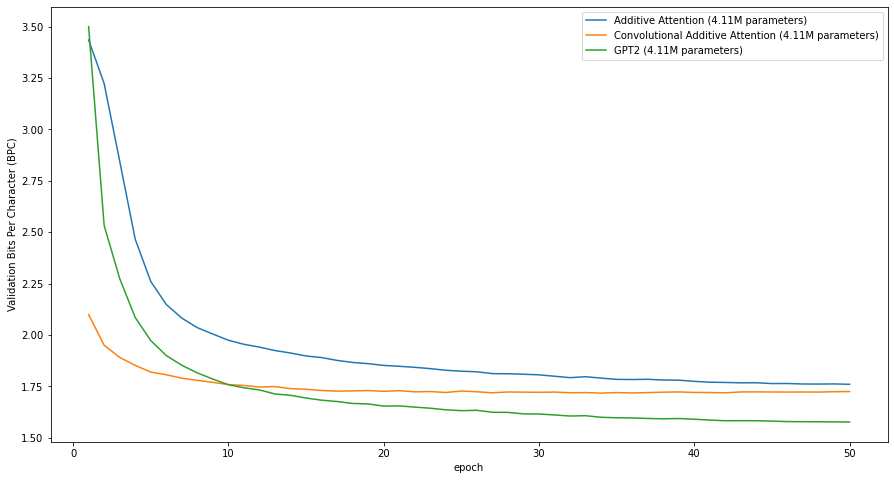

In [87]:
BPC_results.plot()

plt.ylabel("Validation Bits Per Character (BPC)")
#plt.axhline(y=BPC_results["Additive Attention (4.15M parameters)"].min(), linestyle='--', label = "Minimum Additive Attention Validation BPC")
plt.legend()
plt.savefig('results.png')
plt.show()

# Appendix

In [ ]:
test_number = 94

input_ids = lm_dataset["train"][test_number]["input_ids"].reshape(1, -1).cpu()
attention_mask = lm_dataset["train"][test_number]["attention_mask"].reshape(1, -1).cpu()
labels = lm_dataset["train"][test_number]["labels"].reshape(1, -1).cpu()

In [ ]:
test_model = FastformerForCausalLM(config)
test_model.load_state_dict(torch.load("./results\checkpoint-33400\pytorch_model.bin"))

test_model = test_model.cpu().eval()
out = test_model(input_ids=input_ids, labels = labels, attention_mask = attention_mask)
logits = out.logits
loss = out.loss
loss

In [ ]:
generated_tokens = test_model.generate(input_ids[:,:50], do_sample=True, max_length=256, temperature = .01)
tokenizer.batch_decode(generated_tokens)